# Simulating neural computation with Brian 2
## Preliminary remarks: the jupyter notebook

The [jupyter notebook](http://jupyter.readthedocs.io/) is a tool to mix text, code, and results/figures generated by the code in a single document that can be shared and remains editable.

We here use it with Python, but support for other programming languages exists.

Code written in a cell will be executed when you press `Ctrl+Enter` or `Shift+Enter` (this will also jump to the next code cell, or open a new code cell if none exists):

In [1]:
3 + 4

7

Text can be formatted using the light-way formatting language [markdown](https://daringfireball.net/projects/markdown/syntax). You can have for example text in *italics* or **bold**. It also allows you to write mathematical expressions using LaTeX syntax: $\sqrt 2$ (double click a formatted cell to see its "source code")

Let's import "everything" from the Brian 2 package.

This also provides access to the scientific computing package [numpy](http://www.numpy.org/) (imported as `np`), and to the package `pyplot` from the plotting library [matplotlib](http://matplotlib.org) (imported as `plt`).

## Modelling neurons with Brian

In [2]:
from brian2 import *
prefs.codegen.target = 'numpy'  # Switch off the C++ code generation mechanism -- not necessary in general,
                                # but can speed up simple models and avoid annoying warnings

Include plots directly in the notebook and keep them interactive (zoomable, etc.):

(If this does not work (e.g. because the version of matplotlib is too old), try `%matplotlib inline"`instead, which includes static plots in the notebook)

In [3]:
%matplotlib notebook

Brian provides a system for physical units:

In [4]:
Rm = 1*Mohm
I = 50*nA

Operations with physical quantities lead to new quantities with potentially different units:

In [5]:
Rm * I

50. * mvolt

Brian will complain if operations do not make sense:

In [6]:
Rm + I

DimensionMismatchError: Cannot calculate 1. Mohm + 50. nA, units do not match (units are ohm and amp).

(Python error messages are very verbose: have a look at the *end* of the error message first!)

Let's define a simplified integrate-and-fire model (everything has been multiplied by the membrane resistance $R_m$, so the right-hand side is not divided by $C_m$, but instead by $\tau_m = R_m C_m$): 

In [7]:
tau_m = 5*ms
V_r = -70*mV
eqs = 'dV/dt = (V_r - V)/tau_m : volt'
neurons = NeuronGroup(1, model=eqs)
neurons.V = -65*mV

We can now run this model for a certain time:

In [8]:
run(10*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.06s). [brian2.stateupdaters.base.method_choice]


(Let's ignore the warning for now).

After 10 ms, the membrane potential should have relaxed towards the resting potential $V_r$:

In [9]:
neurons.V

<neurongroup.V: array([-69.32332358]) * mvolt>

If we want to look at the development of the membrane potential over time, we'll have to tell Brian to record the values of `V` during the simulation:

In [10]:
tau_m = 5*ms
V_r = -70*mV
eqs = 'dV/dt = (V_r - V)/tau_m : volt'
neurons = NeuronGroup(1, model=eqs)
neurons.V = -65*mV

monitor = StateMonitor(neurons, 'V', record=True)  # record=True means "record all neurons"

In [11]:
run(10*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


Now we can plot the values using Python's plotting library. Note that we divide the physical quantitities by the scale we are interested in to get values "in ms" or "in mV":

<IPython.core.display.Javascript object>


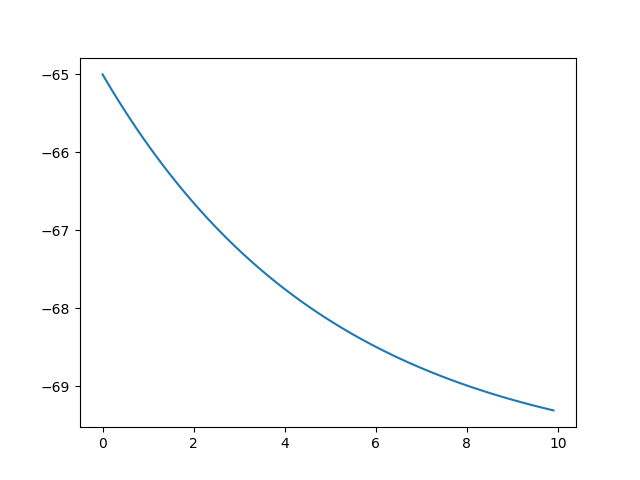

In [12]:
plt.plot(monitor.t/ms, monitor.V[0]/mV)

To get rid of the distracting "Out" line, we can add a semicolon at the end of the line (something that is only relevant to the last line of a code cell when running things in an interactive environment like the jupyter notebook -- you *don't* have to add a semicolon to every line!). Also, to avoid plotting into the same figure again and again (this is not an issue if using `%matplotlib inline`), we should also explicitly create a new figure and plot into this figure. We'll use the same syntax later to have plots with multiple subplots:

<IPython.core.display.Javascript object>


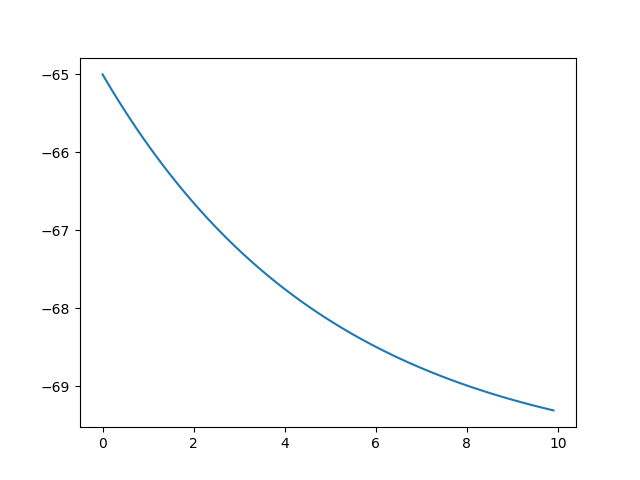

In [13]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V[0]/mV);

Constants defined outside of the equations (e.g. $\tau_m$ in our case) are the same for all neurons in a group. If we want to have neuron-specific values, we'll have to include them in the equations. We do this for a constant current input $I_e$ that can have differing strengths for each neuron (note that this "current" has units of voltage, because of our "everything multiplied by $R_m$" formulation of the integrate-and-fire model).

When setting initial conditions, we can provide a string that defines a mathematical expression to be evaluated for each neuron. In it we can refer to constants and neuronal state variables, as well as to a few predefined variables such as $i$, the index of the neuron.

Let's also get rid of the information about the integration algorithm: Brian emits this message because we did not explicitly say how the equations should be integrated. In this case, Brian decides which integration algorithm to use and tells us about its choice. In our case, the equations are simple enough to be solved analytically, we therefore chose the method `'exact'` (other options would be for example `'euler'` to integrate with the --fast but not accurate-- forward Euler, or `'rk4'` to integrate with a fourth-order Runge-Kutta method):

In [14]:
tau_m = 5*ms
V_r = -70*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact')
neurons.V = -65*mV
neurons.I_e = 'i*1*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [15]:
run(10*ms)

To plot the voltages of all 10 neurons at once, we can plot `monitor.V` (instead of `monitor.V[0]` etc.). However, matplotlib wants the first dimension (i.e., the number of rows) of `monitor.V` to be the same as the dimension of `monitor.t`, but the first dimension of `monitor.V` is the neuron index. We therefore have to transpose the matrix, i.e. use `monitor.V.T`:

<IPython.core.display.Javascript object>


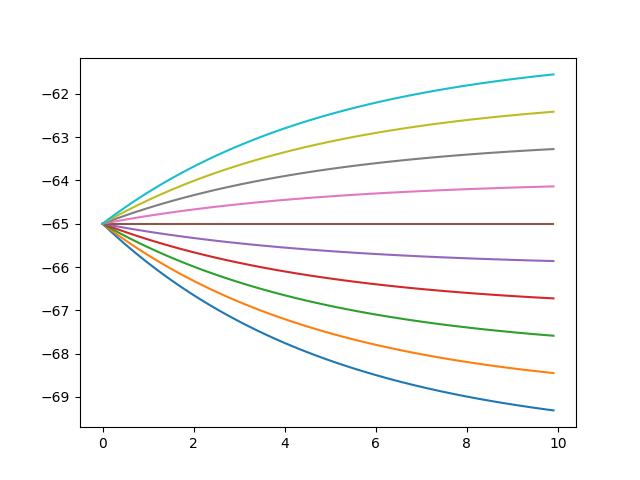

In [16]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

Our neuron does not emit any spikes yet. To make it into an actual integrate-**and-fire** neuron, we have to define a "threshold condition" (when does the neuron emit a spike?) and a "reset statement" (what should the neuron do after a spike was emitted?). We also increase the strength of the input current a bit to make sure we see spikes.

In [17]:
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r')
neurons.V = -65*mV
neurons.I_e = 'i*5*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [18]:
run(10*ms)

<IPython.core.display.Javascript object>


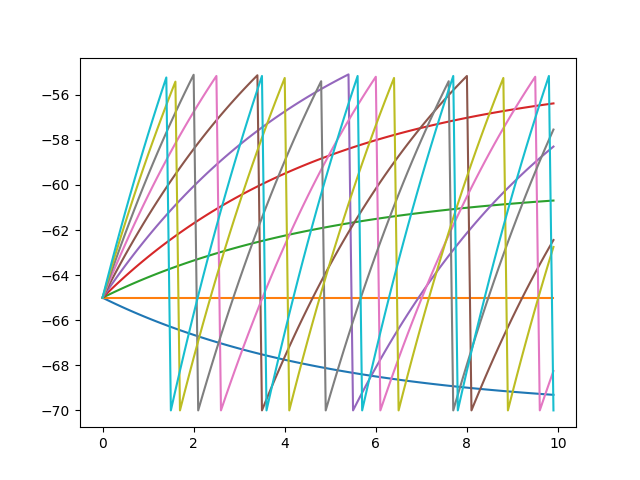

In [19]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

(Note that for a visualization in a paper, you'd probably add a vertical line for each spike to make the membrane potential look "more realistic")

In the above model, each neurons can fire action potentials at basically arbitrarily high rates for sufficiently strong input currents. Real neurons, however, have a period -- called the refractory period -- after each spike during which it cannot fire action potentials. For this, Brian offers the `refractory` keyword argument:

In [20]:
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'i*5*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [21]:
run(10*ms)

<IPython.core.display.Javascript object>


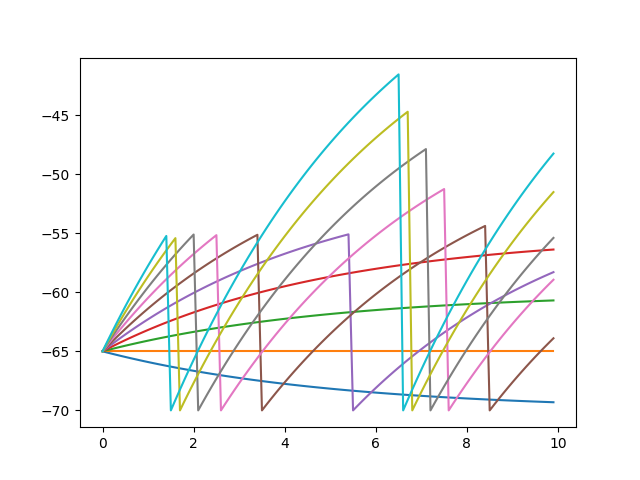

In [22]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

This is not quite what want, though: the neuron cannot spike, but its membrane potential continues to update according to its differential equation, going far beyond the threshold! Instead, we'd like to clamp the membrane potential to the reset potential during the refractory. We can do this in Brian by declaring that $V$ should follow the differential equation, except during the refractory period:

In [23]:
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         I_e : volt'''
neurons = NeuronGroup(10, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'i*5*mV'

monitor = StateMonitor(neurons, 'V', record=True)

In [24]:
run(10*ms)

<IPython.core.display.Javascript object>


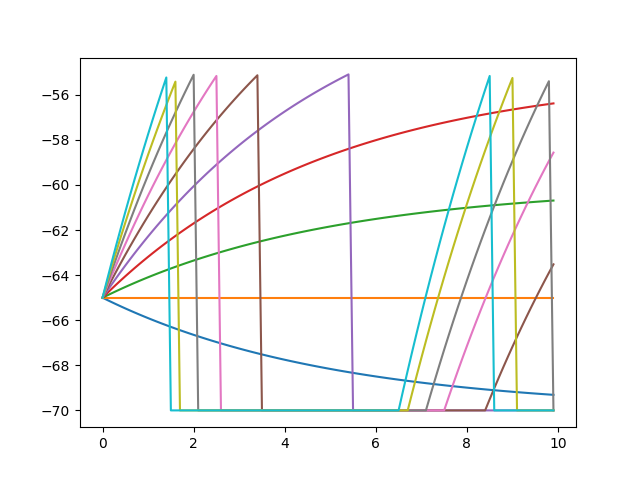

In [25]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

In [26]:
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt'''
neurons = NeuronGroup(10, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'i*5*mV'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)

## Modelling synapses with Brian

The "input" our cell received in the previous model was a constant current input. While we can inject constant currents into neurons during an experiment, the membrane potential of neurons under normal conditions is mostly affect by the temporary currents arising from the impact of chemical synapses. As a first step towards modeling such synapses, we make our current temporary (decaying explonentionally to zero). We'll also record the evolution of this current over time by including it in our `StateMonitor`:

In [27]:
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt'''
neurons = NeuronGroup(10, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV
neurons.I_e = 'i*5*mV'

monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)

In [28]:
run(10*ms)

We'll use the `subplots` function to create two rows (and one colum) of plots, the `ax` variable is now a list of two axes that we can index with `[..]` (remember that indices in Python start at 0):

<IPython.core.display.Javascript object>


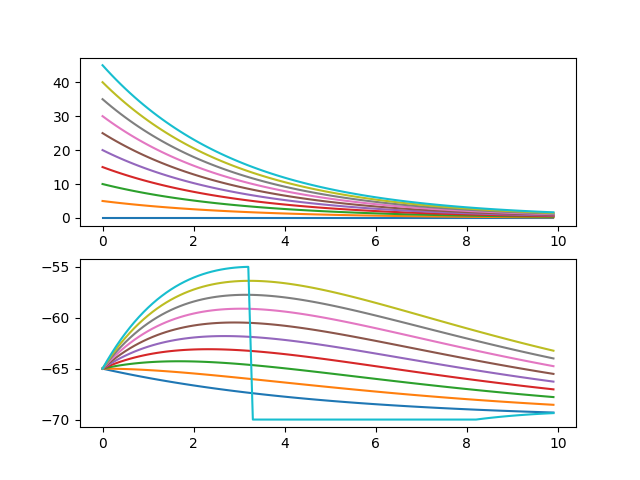

In [29]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(monitor.t/ms, monitor.I_e.T/mV)
ax[1].plot(monitor.t/ms, monitor.V.T/mV);

Let's leave aside our neural model for a moment and look at other ways to generate spikes, useful to serve as input to a network of neurons. We'll first have a look at a `SpikeGeneratorGroup` which can be used to emit a pre-defined pattern of spikes. To check whether it does the right thing, we record these spikes using a `SpikeMonitor`. For example, let's define a group of 3 "neurons" that spikes at 2ms, 4ms, and 6ms, respectively.

Note that from now on, we'll always start the definition of new networks with `start_scope` -- this is necessary so that Brian knows which elements to simulate when we type `run` (the neurons that we defined previously are still around!). With `start_scope`, we tell Brian to forget everything that was defined before.

In [30]:
start_scope()

# Syntax: (number of neurons, neuron indices, spike times for these neurons)
spikes = SpikeGeneratorGroup(3, [0, 1, 2], [2, 4, 6]*ms)

spike_mon = SpikeMonitor(spikes)

In [31]:
run(10*ms)

<IPython.core.display.Javascript object>


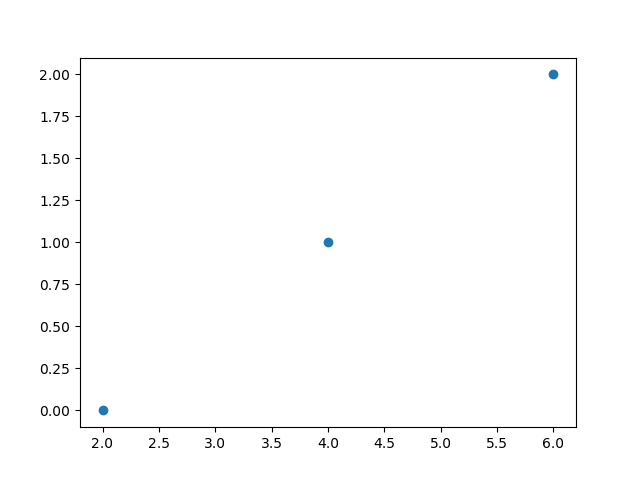

In [32]:
fig, ax = plt.subplots()
ax.plot(spike_mon.t/ms, spike_mon.i, 'o');

Repeated spike patterns can be generated using the `period` argument:

In [33]:
start_scope()

# Syntax: (number of neurons, neuron indices, spike times for these neurons)
spikes = SpikeGeneratorGroup(3, [0, 1, 2], [2, 4, 6]*ms, period=10*ms)

spike_mon = SpikeMonitor(spikes)

In [34]:
run(100*ms)

<IPython.core.display.Javascript object>


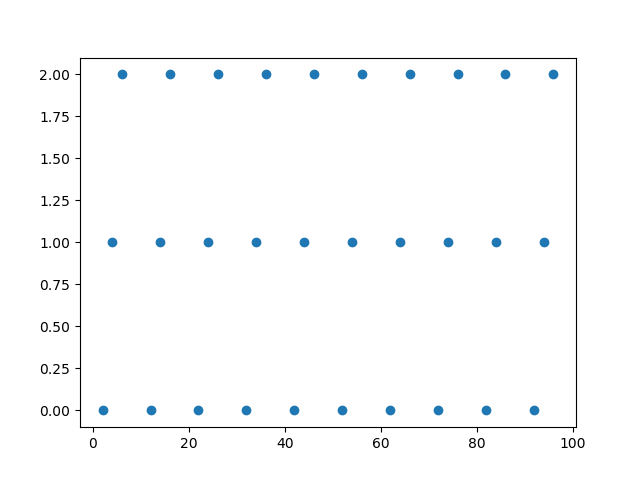

In [35]:
fig, ax = plt.subplots()
ax.plot(spike_mon.t/ms, spike_mon.i, 'o');

Another useful way of generating inputs is the `PoissonGroup`, which generates spikes generated by a Poisson process. You can provide individual firing rates for each neuron, or a single firing rate for all neurons:

In [36]:
start_scope()

spikes = PoissonGroup(3, rates=100*Hz)

spike_mon = SpikeMonitor(spikes)

In [37]:
run(100*ms)

<IPython.core.display.Javascript object>


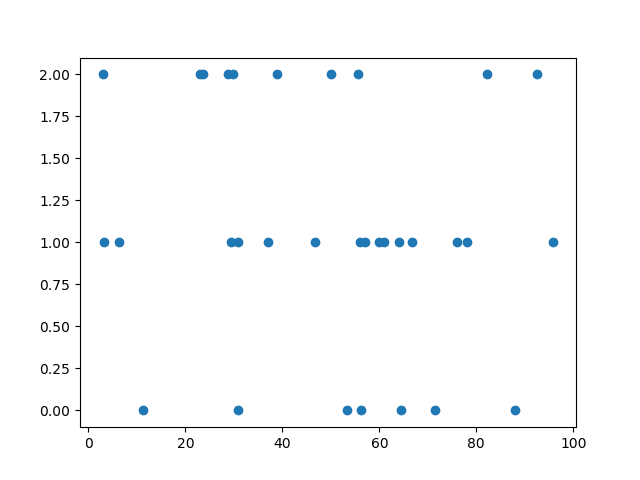

In [38]:
fig, ax = plt.subplots()
ax.plot(spike_mon.t/ms, spike_mon.i, 'o');

We are now going to connect this source of spikes to our neuron model defined previously. We do this using the `Synapses` class which in addition to the source and target groups, requires us to specify the action that the arrival of a presynaptic spike (hence: `on_pre`) causes. Creating such a `Synapses` object will not yet create synapses (there are many ways in which you could connect two groups), we will have to call the `connect` function to do this. Calling `connect()` without any arguments means: "connect everything in the source group to everything in the target group" (i.e., "all-to-all"):

In [39]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt'''
neurons = NeuronGroup(10, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV

spikes = PoissonGroup(3, rates=100*Hz)
spike_mon = SpikeMonitor(spikes)
monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)

synapses = Synapses(spikes, neurons, on_pre='I_e += 1*mV')
synapses.connect()

In [40]:
run(100*ms)

<IPython.core.display.Javascript object>


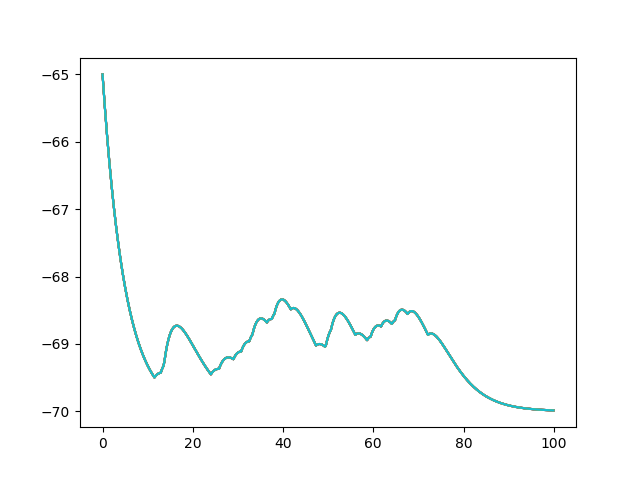

In [41]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

We plotted the activity of all 10 neurons, but they all do the same thing. This is not surprising since they receive the same input from the same Poisson spike sources and all synapses have the same strength. If instead we want to have individual synaptic weights for each connection, we need to include the weight in the synaptic equations (similar to the constant current $I_e$ in the neuronal equations in the very beginning). We'll initialize these weights randomly by using the `rand()` function provided by Brian:

In [42]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
eqs = '''dV/dt = ((V_r - V) + I_e)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt'''
neurons = NeuronGroup(10, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV

spikes = PoissonGroup(3, rates=100*Hz)
spike_mon = SpikeMonitor(spikes)
monitor = StateMonitor(neurons, ['V', 'I_e'], record=True)

synapses = Synapses(spikes, neurons, model='w: volt',
                    on_pre='I_e += w')
synapses.connect()
synapses.w = 'rand() * 2*mV'

In [43]:
run(100*ms)

<IPython.core.display.Javascript object>


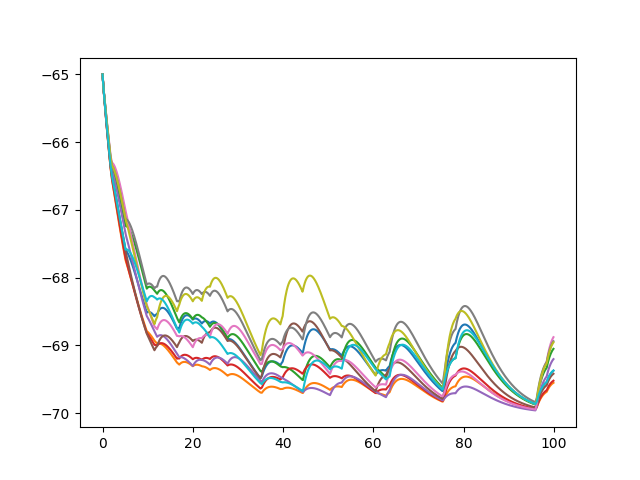

In [44]:
fig, ax = plt.subplots()
ax.plot(monitor.t/ms, monitor.V.T/mV);

Let's implement a well-studied plasticity rule: spike-timing dependent plasticity (STDP; also see the slides). More specifically, our variant will be "additive STDP" using "all-to-all spike interaction". The typical implementation of STDP uses "synaptic traces" that reflect the pre- and post-synaptic activity. When these traces are increased for each pre/post-synaptic spike and then decay back to zero exponentially, they can be used to implement STDP rules that depend exponentially on the time difference between pre- and post-synaptic spikes as follows:
* **When a pre-synaptic spike arrives**:
  1. Propagate the spike to the post-synaptic target (e.g., increase $I_e$)
  2. Increase the pre-synaptic trace by $A_{fac}$
  3. Update the synaptic weight using the current value of the *post-synaptic* trace
* **When a post-synaptic spike arrives**:
  1. Increase the post-synaptic trace by $A_{dep}$
  2. Update the synaptic weight using the current value of the *pre-synaptic* trace
* **In the absence of spikes**:
  Let the pre- and post-synaptic traces decay exponentially

When $A_{fac}$ is positive and $A_{dep}$ is negative, this implements the typical "pre before post = facilitation", "post before pre = depression" STDP rule. To convince yourself of this, consider the following situation:
A pre-synaptic spike arrives at time $t_1$ and the post-synaptic cell spikes later at $t_2$: At $t_1$, the pre-synaptic trace gets bumped up by $A_{fac}$ and the weight does not change (because the post-synaptic trace is at 0). At $t_2$ the post-synaptic trace gets bumped up by $A_{dep}$ and the weight changes by the current value of the pre-synaptic trace. That value is now $A_{fac} e^{-\frac{(t_2-t_1)}{\tau_{trace}}}$, where $\tau_{trace}$ is the time constant of the exponential decay. The change will therefore be greater when the two spikes are close together. You can go through the same steps for a post-before-pre pairing: the depression will be stronger for small time differences in the two spikes.

We'll write this model in Brian, and test it with artificially generated spikes with varying relative timings:

In [45]:
start_scope()
# Neurons in the first group spike between 0 and 40ms
spikes1 = SpikeGeneratorGroup(100, np.arange(100),
                              np.linspace(0, 40, 100)*ms)
# The single neuron in the second group spikes at 20ms
spikes2 = SpikeGeneratorGroup(1, [0], [20]*ms)
A_pot = 0.1*mV
A_dep = -0.1*mV
tau_trace = 20*ms
synapses = Synapses(spikes1, spikes2,
                    model='''dpre_trace/dt = -pre_trace/tau_trace : volt
                             dpost_trace/dt = -post_trace/tau_trace : volt
                             w : volt
                    ''',
                    on_pre='''pre_trace += A_pot
                              w += post_trace''',
                    on_post='''post_trace += A_dep
                               w += pre_trace''', method='exact')
# There are a 100 synapses, each will see pre-post spike pair,
# with different relative timings between -20ms and 20ms:
synapses.connect()
synapses.w = 1*mV
run(41*ms)

INFO       The synaptic equation for the variable pre_trace does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable post_trace does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


(ignore the INFO messages about "clock-driven" for now)

Let's plot the change in the synapse over the relative timing:

<IPython.core.display.Javascript object>


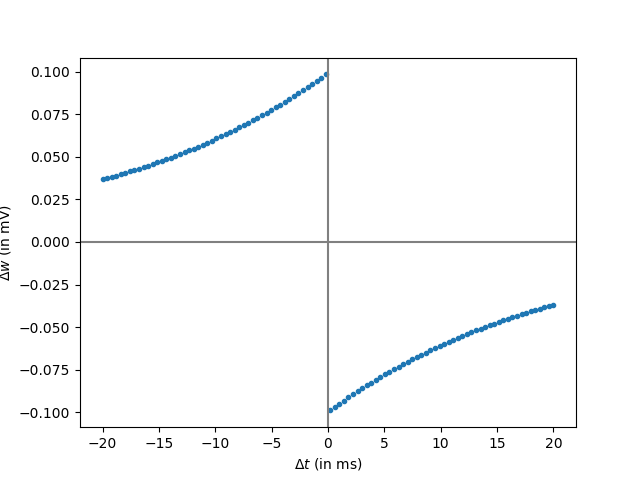

In [46]:
fig, ax = plt.subplots()
ax.plot((np.linspace(0, 40, 100)*ms - 20*ms)/ms,  # Relative timing between pre and post
        (synapses.w - 1*mV)/mV,  # Change compared to the initial weight
        '.');
# A few things to make the plot easier to understand:
ax.axvline(0, color='gray')  # vertical line at 0ms
ax.axhline(0, color='gray')  # horizontal line at 0mV
ax.set(xlabel='$\Delta t$ (in ms)', ylabel='$\Delta w$ (in mV)');

Some remarks about the info message about the "clock-driven" calculation of `pre_trace` and `post_trace`: large networks of neurons will have many synapses and the calculations that need to be done "per synapse" quickly dominate the total simulation time. By default, Brian uses a "clock-driven" approach to simulate differential equations, i.e. the state variables are updated every time step according to the differential equations. However, we don't actually need all the intermediate values of the traces, we only need their values whenever a pre- or post-synaptic spike arrives. Luckily, the differential equations governing their evolution are very simple (exponential decay) and we can solve them analytically. This means, instead of updating them every time step, we can update them only whenever a spike pre- or post-synaptic to the given synapse occured, calculating the effect of the exponential decay based on the time since the last update. Brian can do this calculation for us, all that is needed to mark the equations as "event-driven":

In [47]:
start_scope()
# Neurons in the first group spike between 0 and 40ms
spikes1 = SpikeGeneratorGroup(100, np.arange(100),
                              np.linspace(0, 40, 100)*ms)
# The single neuron in the second group spikes at 20ms
spikes2 = SpikeGeneratorGroup(1, [0], [20]*ms)
A_pot = 0.1*mV
A_dep = -0.1*mV
tau_trace = 20*ms
synapses = Synapses(spikes1, spikes2,
                    model='''dpre_trace/dt = -pre_trace/tau_trace : volt (event-driven)
                             dpost_trace/dt = -post_trace/tau_trace : volt (event-driven)
                             w : volt
                    ''',
                    on_pre='''pre_trace += A_pot
                              w += post_trace''',
                    on_post='''post_trace += A_dep
                               w += pre_trace''', method='exact')
# There are a 100 synapses, each will see pre-post spike pair,
# with different relative timings between -20ms and 20ms:
synapses.connect()
synapses.w = 1*mV
run(41*ms)

When the network has many synapses, this speeds up simulations significantly. It does not change the model in any way, the results therefore stay the same:

<IPython.core.display.Javascript object>


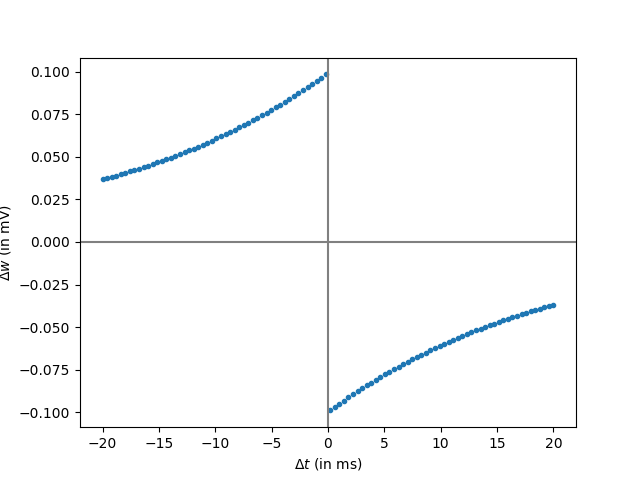

In [48]:
fig, ax = plt.subplots()
ax.plot((np.linspace(0, 40, 100)*ms - 20*ms)/ms,  # Relative timing between pre and post
        (synapses.w - 1*mV)/mV,  # Change compared to the initial weight
        '.');
# A few things to make the plot easier to understand:
ax.axvline(0, color='gray')  # vertical line at 0ms
ax.axhline(0, color='gray')  # horizontal line at 0mV
ax.set(xlabel='$\Delta t$ (in ms)', ylabel='$\Delta w$ (in mV)');

## Case study: learning patterns with STDP

[See the slides with some figures from the paper]
STDP learning rules have been shown to make synapses sensitive to repeated spatio-temporal patterns. We can reproduce this in a simplified model -- although, as you saw in the course, the model is highly random and for a small network run for a relatively short time it does not always work.

Let's first explicitly create random spikes drawn from a Poisson distribution. To make this easy, well construct a grid of bins (number of neurons x time bins). For a Poisson process, the probability for such a bin to contain a spike is simply $p = r \cdot b$, where $r$ is the firing rate and $b$ is the bin size. This will give us a matrix of `True`/`False` (bin contains a spike/bin does not contain a spike) values:

In [49]:
N = 10000  # 10000 "neurons"
bin_size = 2*ms
p = 1*Hz*bin_size  # Firing rate per neuron: 1Hz
total = 10*second  # Total length of our stimulus

spikes = np.random.rand(N, int(total/bin_size)) < p

We want now to impose a random pattern of the same statistics, but repeated again and again during the 10 seconds. We simply chose the first 250ms of the pattern to be repeated every second:

In [50]:
pattern_length = 250*ms
pattern = spikes[:, 0:int(pattern_length/bin_size)]

We now replace the time windows 0-250ms, 1.0s-1.25s, 2.0s-2.25s, ... by this pattern:

In [51]:
repeat_every = pattern_length * 4
n_repetitions = int(total/repeat_every)

for rep in np.arange(n_repetitions):
    spikes[:, rep*int(repeat_every/bin_size):rep*int(repeat_every/bin_size)+int(pattern_length/bin_size)] = pattern

Finally, we convert this matrix into a format that we can use in a `SpikeGeneratorGroup`, i.e. a list of row indices (neuron indices) and a list of column indices (spike times) where the matrix contains `True` values:

In [52]:
indices, time_bins = spikes.nonzero()

To get the actual times, we have to multiply the bins with the bin size:

In [53]:
times = time_bins * bin_size

Let's plot this stimulation, adding grey boxes to show the windows with the repeated spike patterns (we'll only plot a subset of 500 neurons):

<IPython.core.display.Javascript object>


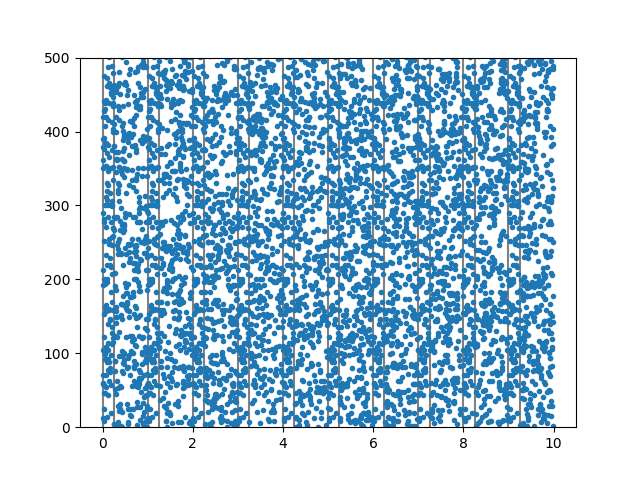

In [54]:
fig, ax = plt.subplots()
ax.plot(times/second, indices, '.')
# Add lines to show the repeated stimulation windows
ax.vlines(np.arange(n_repetitions)*repeat_every/second, 0, 500, color='gray')
ax.vlines(np.arange(n_repetitions)*repeat_every/second + pattern_length/second, 0, 500, color='gray')
# Restrict the plot to the first 500 neurons
ax.set(ylim=(0, 500));

If you look closely, you see that the spike pattern within the gray lines is always identical, but otherwise these time periods are not remarkable in any way (same average firing over neurons/time).

For simplicity, we'll later repeat the whole pattern after 10 seconds (in the original study, we did not do that).

We'll now use this stimulation + our previously defined neuron model + the STDP synapse model (with the addition that synaptic weights are restricted to stay between 0 and $w_{max}$ using the `clip` function).

We'll also add inhibitory synapses with a constant weight that are not subject to any plasticity.

In contrast to earlier simulations where we connected synapses as "all-to-all", we now connect the first 8000 neurons (indices $i < 8000$) with excitatory synapses, and the last 2000 neurons with inhibitory synapses. We'll also initialize the synaptic weights in a bit peculiar way: weights are random but skewed towards 0 (this is closer to the distribution that you would see if you let the network run for a long time with random input).

Finally, we use normalization factors $\lambda_e$ and $\lambda_i$ that depend on the time constants and make it easier to interpret the synaptic weights: with these factors, a weight of 1mV will lead to a peak change in the post-synaptic membrane potential of 1mV.

In [55]:
start_scope()
tau_m = 5*ms
V_r = -70*mV
V_th = -55*mV
tau_e = 3*ms
tau_i = 10*ms
lambda_e = (tau_e / tau_m) ** (tau_m / (tau_e - tau_m))
lambda_i = (tau_i / tau_m) ** (tau_m / (tau_i - tau_m))
tau_trace = 20*ms
w_max = 2*mV
A_pot = 0.02*w_max
A_dep = -1.2*A_pot
eqs = '''
dV/dt = ((V_r - V) + I_e + I_i)/ tau_m : volt (unless refractory)
dI_e/dt = -I_e/tau_e : volt
dI_i/dt = -I_i/tau_i : volt
'''
neurons = NeuronGroup(100, model=eqs, method='exact',
                      threshold='V > V_th', reset='V = V_r',
                      refractory=5*ms)
neurons.V = V_r

N_e = 8000
N_i = 2000
N = N_e + N_i
spikes = SpikeGeneratorGroup(N, indices, times, period=total)

e_synapses = Synapses(spikes, neurons,
                    '''w : volt
                       dpre_trace/dt = -pre_trace / tau_trace : volt (event-driven)
                       dpost_trace/dt = -post_trace / tau_trace : volt (event-driven)''',
                       on_pre='''I_e += lambda_e*w
                                 pre_trace += A_pot
                                 w = clip(w + post_trace, 0, w_max)''',
                       on_post='''post_trace += A_dep
                                  w = clip(w + pre_trace, 0, w_max)''')
e_synapses.connect('i<N_e')
e_synapses.w = 'rand()**4 * 2*mV'

i_synapses = Synapses(spikes, neurons, on_pre='I_i -= lambda_i*1*mV')
i_synapses.connect('i>=N_e')

mon = StateMonitor(neurons, 'V', record=0)

spike_mon = SpikeMonitor(neurons)

As mentioned above, our initial distribution of synaptic weights is skewed towards 0. We can plot a histogram of the weights to visualize this:

<IPython.core.display.Javascript object>


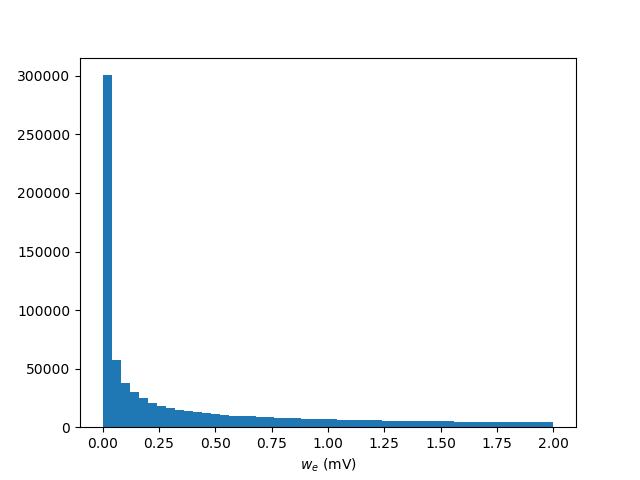

In [56]:
fig, ax = plt.subplots()
ax.hist(e_synapses.w/mV, bins=50)
ax.set(xlabel='$w_e$ (mV)');

We now run this simulation for 100s, i.e. for 10 repetitions of our stimulus (i.e. a total of 100 repetitions of our short repeated stimulus), adding `report='text'` to ask Brian to keep us updated about the simulation progress:

In [57]:
run(total*10, report='text')

Starting simulation at t=0. s for a duration of 100. s
7.0338 s (7%) simulated in 10s, estimated 2m 12s remaining.
14.0523 s (14%) simulated in 20s, estimated 2m 2s remaining.
20.8678 s (20%) simulated in 30s, estimated 1m 54s remaining.
27.5148 s (27%) simulated in 40s, estimated 1m 45s remaining.
34.1043 s (34%) simulated in 50s, estimated 1m 37s remaining.
40.5556 s (40%) simulated in 1m 0s, estimated 1m 28s remaining.
47.0762 s (47%) simulated in 1m 10s, estimated 1m 19s remaining.
53.633 s (53%) simulated in 1m 20s, estimated 1m 9s remaining.
60.1352 s (60%) simulated in 1m 30s, estimated 1m 0s remaining.
66.7266 s (66%) simulated in 1m 40s, estimated 50s remaining.
72.9275 s (72%) simulated in 1m 50s, estimated 41s remaining.
78.9541 s (78%) simulated in 2m 0s, estimated 32s remaining.
84.8781 s (84%) simulated in 2m 10s, estimated 23s remaining.
90.9444 s (90%) simulated in 2m 20s, estimated 14s remaining.
97.1033 s (97%) simulated in 2m 30s, estimated 4s remaining.
100. s (100%

If we look at the distribution of synapses after the run, it looks almost unchanged. However, there's a new little bump at the right end (i.e. synapses at their maximum value):

<IPython.core.display.Javascript object>


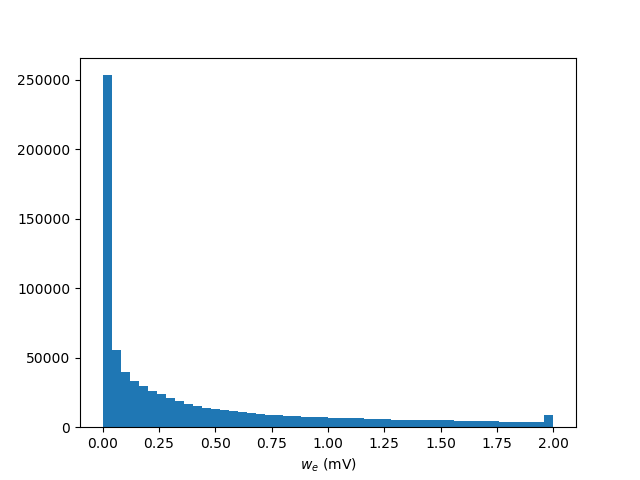

In [58]:
fig, ax = plt.subplots()
ax.hist(e_synapses.w/mV, bins=50)
ax.set(xlabel='$w_e$ (mV)');

Let's look at the spiking activity of our target population at the beginning of the simulation (first 5s):

<IPython.core.display.Javascript object>


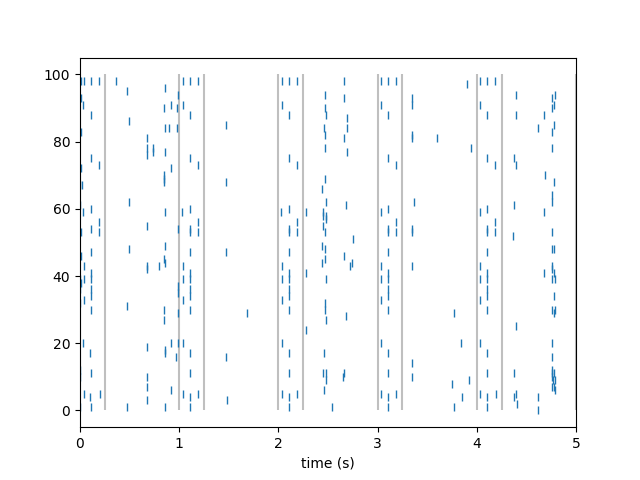

In [59]:
fig, ax = plt.subplots()
ax.vlines(np.arange(n_repetitions*10)*repeat_every/second, 0, 100, color='gray', alpha=0.5)
ax.vlines(np.arange(n_repetitions*10)*repeat_every/second + pattern_length/second, 0, 100, color='gray', alpha=0.5)
ax.plot(spike_mon.t/second, spike_mon.i, '|')
ax.set(xlim=(0, 5), xlabel='time (s)');

If you look closely, the activity within the "gray boxes" looks similar over repetitions (not too surprising: the input is the same!). Apart from that, it does not look fundamentally different to the periods between the repetitions.

Now, what does the activity look like in the last 5s:

<IPython.core.display.Javascript object>


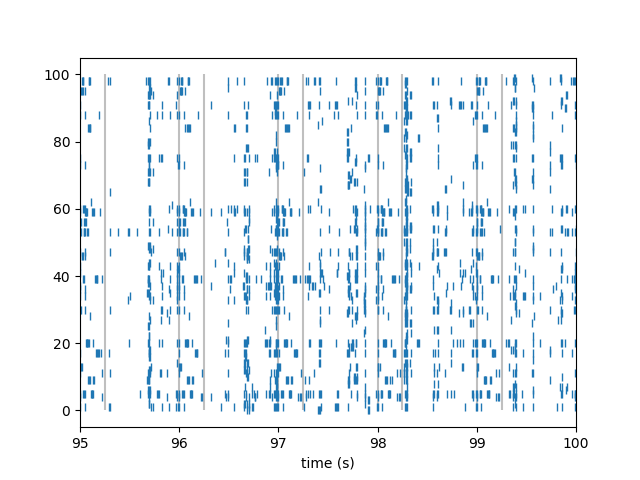

In [60]:
fig, ax = plt.subplots()
ax.vlines(np.arange(n_repetitions*10)*repeat_every/second, 0, 100, color='gray', alpha=0.5)
ax.vlines(np.arange(n_repetitions*10)*repeat_every/second + pattern_length/second, 0, 100, color='gray', alpha=0.5)
ax.plot(spike_mon.t/second, spike_mon.i, '|')
ax.set(xlim=(95, 100), xlabel='time (s)');

The activity over neurons is somewhat higher during the "repeat" periods, but more importantly, some neurons have become "pattern detectors" for the pattern and strongly increase their firing rate during these periods.
As said in the beginning, though, -- and as seen at the end of the course --, this does not happen every time; with an unlucky combination of spike patterns and initial weight distributions, this effect might not appear in a short simulation like this.